Notes:
The linear regression model that worked the best was the 14th percentile with feature engineering v1. Next steps:
- Fit linear regression model with regulization and automatically remove those features.
- Add more feature engineering from v2 and monitor how it affects the model

In [123]:
#8.97
#11.69

In [136]:
# Import libraries needed for linear regression computation
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import log
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import SelectPercentile
import scipy.stats as stats
import pylab 
import seaborn as sns
from sklearn.metrics.pairwise import euclidean_distances
from operator import itemgetter
from sklearn.decomposition import PCA
%matplotlib inline

In [125]:
# LR Function

In [2]:
def run_model_inputs(train_data, train_id, train_saleprice, test_data, test_id):
    # Build a model with all features to simply predict sales price
    train_X, validate_X, train_y, validate_y = train_test_split(
        train_data, train_saleprice, test_size=0.2, random_state=43344)

    model = sm.OLS(train_y, sm.add_constant(train_X)).fit()
    print('R2 is:', model.rsquared)
    print(model.summary())
    # Let's get the train and test RMSE to compare
    train_predictions = model.predict(sm.add_constant(train_X))
    # print('The training RMSE is ', sqrt(mean_squared_error(train_y, train_predictions)), '!')
    avg_train_err = ((abs(train_y - train_predictions))/train_y)
    print('Training average percent error is', round(avg_train_err.mean()*100,2), '%.')


    validate_predictions = model.predict(sm.add_constant(validate_X))
    # print('The testing RMSE is ', sqrt(mean_squared_error(test_y, test_predictions)), '!')

    avg_test_err = ((abs(validate_y - validate_predictions))/validate_y)
    print('Validation average percent error is',round(avg_test_err.mean()*100,2), '%.')
    
    print('Difference is:', round(abs(avg_test_err.mean() - avg_train_err.mean())*100,2))
    # Plot the residual plot along with the QQ-Plot
    
    # fitted values
    model_fitted = pd.DataFrame(model.fittedvalues)

    # model residuals
    model_residuals = pd.DataFrame(model.resid)

    # Residual plot
    residual_plot = plt.scatter(model_fitted , model_residuals)
    plt.show()

    #QQ-plot
    stats.probplot(model_residuals[0], dist='norm', plot=pylab)
    pylab.show()
    
    test_predictions = model.predict(sm.add_constant(test_data))
    test_predictions = pd.DataFrame(test_predictions)
    test_predictions.columns = ['SalePrice']
    test_predictions = pd.concat([test_id, test_predictions], axis=1)
    
    return test_predictions


def run_model_inputs_w_reg(train_data, train_id, train_saleprice, test_data, test_id, alpha_weight, lt_weight):
    
    # Build a model with all features to simply predict sales price
    train_X, validate_X, train_y, validate_y = train_test_split(
        train_data, train_saleprice, test_size=0.2, random_state=43344)

    model = sm.OLS(train_y, sm.add_constant(train_X)).fit_regularized(method='elastic_net', alpha=alpha_weight, L1_wt =lt_weight)
#     print('R2 is:', model.rsquared)
    
    # Let's get the train and test RMSE to compare
    train_predictions = model.predict(sm.add_constant(train_X))
    # print('The training RMSE is ', sqrt(mean_squared_error(train_y, train_predictions)), '!')
    avg_train_err = ((abs(train_y - train_predictions))/train_y)
    print('Training average percent error is', round(avg_train_err.mean()*100,2), '%.')


    validate_predictions = model.predict(sm.add_constant(validate_X))
    # print('The testing RMSE is ', sqrt(mean_squared_error(test_y, test_predictions)), '!')

    avg_test_err = ((abs(validate_y - validate_predictions))/validate_y)
    print('Validation average percent error is',round(avg_test_err.mean()*100,2), '%.')
    
    print('Difference is:', round(abs(avg_test_err.mean() - avg_train_err.mean())*100,2) )
    
    test_predictions = model.predict(sm.add_constant(test_data))
    test_predictions = pd.DataFrame(test_predictions)
    test_predictions.columns = ['SalePrice']
    test_predictions = pd.concat([test_id, test_predictions], axis=1)
    
    return test_predictions


# Feature Engineering Function V1

In [50]:
def feature_engineering_v1(model_data):
    # test_data has some nulls. Fill them with 0
    model_data['BsmtFullBath'] = model_data['BsmtFullBath'].fillna(0)
    model_data['BsmtHalfBath'] = model_data['BsmtHalfBath'].fillna(0)
    model_data['GarageCars'] = model_data['GarageCars'].fillna(0)
    
    # fill na with 0 in the GarageYrBuilt column
    model_data['GarageYrBlt'] = model_data['GarageYrBlt'].fillna(0.0)
    
    model_data['TotalLotArea'] = model_data['LotFrontage'].fillna(0) + model_data['LotArea']
    model_data = model_data.drop(columns=['LotFrontage', 'LotArea'])
    # This code is for living SF
    model_data['HaveBsmt'] = np.where(model_data['TotalBsmtSF'] == 0, 0,1)
    model_data['Have2ndFlr'] = np.where(model_data['2ndFlrSF'] == 0, 0,1)
    model_data['living_SF'] = (model_data['1stFlrSF'].fillna(0) + model_data['2ndFlrSF'].fillna(0) 
                               + model_data['TotalBsmtSF'].fillna(0))
    # Also dropping the lowqualitySF feature
    model_data = model_data.drop(columns=['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'LowQualFinSF'])
    
    # Make binary variables for the SF features
    model_data['MasVnrArea'] = model_data['MasVnrArea'].fillna(0)
    model_data['MasVnrAreaBin'] = np.where(model_data['MasVnrArea'] == 0, 0,1)
    model_data['WoodDeckSFBin'] = np.where(model_data['WoodDeckSF'] == 0, 0,1)
    model_data['HaveGarage'] = np.where(model_data['GarageArea'] == 0, 0,1)
    model_data['OpenPorchSFBin'] = np.where(model_data['OpenPorchSF'] == 0, 0,1)
    model_data['EnclosedPorchBin'] = np.where(model_data['EnclosedPorch'] == 0, 0,1)
    model_data['3SsnPorchBin'] = np.where(model_data['3SsnPorch'] == 0, 0,1)
    model_data['ScreenPorchBin'] = np.where(model_data['ScreenPorch'] == 0, 0,1)
    model_data['PoolAreaBin'] = np.where(model_data['PoolArea'] == 0, 0,1)
    
    # Sum up all the SF features as TotalSFfeatures
    model_data['TotalSFFeatures'] = (model_data['MasVnrArea'].fillna(0) + model_data['GarageArea'].fillna(0) 
                                     + model_data['WoodDeckSF'].fillna(0) + model_data['OpenPorchSF'].fillna(0) 
                                     + model_data['EnclosedPorch'].fillna(0) + model_data['3SsnPorch'].fillna(0) 
                                     + model_data['ScreenPorch'].fillna(0) + model_data['PoolArea'].fillna(0))
    
    # Drop the columns that you have applied EDA on
    model_data = model_data.drop(columns=['MasVnrArea','WoodDeckSF', 'GarageArea', 'OpenPorchSF', 
                                          'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea'])
    
    # Apply Feature Engineering on OverallCond and OverallQual columns
    model_data['OverallCondQual'] = (model_data['OverallCond'] * 1)+(model_data['OverallQual'])
    model_data = model_data.drop(columns = ['OverallCond', 'OverallQual'])
    
    # Add int variables for ExterQual and ExterCond
    model_data['ExterQualInt'] =  np.where(model_data['ExterQual'] == "Ex", 9, 
                                            np.where(model_data['ExterQual'] == "Gd", 7, 
                                                    np.where(model_data['ExterQual'] == "TA", 5, 
                                                            np.where(model_data['ExterQual'] == "Fa", 3, 
                                                                    np.where(model_data['ExterQual'] == "Po", 2,0)))))
    model_data['ExterCondInt'] =  np.where(model_data['ExterCond'] == "Ex", 9, 
                                             np.where(model_data['ExterCond'] == "Gd", 7, 
                                                    np.where(model_data['ExterCond'] == "TA", 5, 
                                                            np.where(model_data['ExterCond'] == "Fa", 3, 
                                                                    np.where(model_data['ExterCond'] == "Po", 2,0)))))
    model_data['ExterCondQual'] = (model_data['ExterCondInt']*1) + (model_data['ExterQualInt']*1)
    # Drop original ExterQual and ExterCond and keep int columns
    model_data = model_data.drop(columns=['ExterQual', 'ExterCond'])
    
    # Add int variables for all categorical basement variables
    model_data['BsmtQualInt'] =  np.where(model_data['BsmtQual'] == "Ex", 9, 
                                            np.where(model_data['BsmtQual'] == "Gd", 7, 
                                                    np.where(model_data['BsmtQual'] == "TA", 5, 
                                                            np.where(model_data['BsmtQual'] == "Fa", 3, 
                                                                    np.where(model_data['BsmtQual'] == "Po", 2,0)))))

    model_data['BsmtCondInt'] =  np.where(model_data['BsmtCond'] == "Ex", 9, 
                                            np.where(model_data['BsmtCond'] == "Gd", 7, 
                                                    np.where(model_data['BsmtCond'] == "TA", 5, 
                                                            np.where(model_data['BsmtCond'] == "Fa", 3, 
                                                                    np.where(model_data['BsmtCond'] == "Po", 2,0)))))

    model_data['BsmtExposureInt'] =  np.where(model_data['BsmtExposure'] == "Gd", 7, 
                                            np.where(model_data['BsmtExposure'] == "Av", 5, 
                                                    np.where(model_data['BsmtExposure'] == "Mn", 3, 
                                                            np.where(model_data['BsmtExposure'] == "No", 1, 0))))

    model_data['BsmtFinType1Int'] =  np.where(model_data['BsmtFinType1'] == "GLQ", 9, 
                                            np.where(model_data['BsmtFinType1'] == "ALQ", 7, 
                                                    np.where(model_data['BsmtFinType1'] == "BLQ", 5, 
                                                            np.where(model_data['BsmtFinType1'] == "Rec", 3, 
                                                                    np.where(model_data['BsmtFinType1'] == "LWQ", 1,
                                                                            np.where(model_data['BsmtFinType1'] == "Unf",1,0))))))

    model_data['BsmtFinType2Int'] =  np.where(model_data['BsmtFinType2'] == "GLQ", 9, 
                                            np.where(model_data['BsmtFinType2'] == "ALQ", 7, 
                                                    np.where(model_data['BsmtFinType2'] == "BLQ", 5, 
                                                            np.where(model_data['BsmtFinType2'] == "Rec", 3, 
                                                                    np.where(model_data['BsmtFinType2'] == "LWQ", 1,
                                                                            np.where(model_data['BsmtFinType2'] == "Unf",1,1))))))

    model_data = model_data.drop(columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'])
    
    model_data['BsmtQualCondExposureType'] = (model_data['BsmtFinType2Int'] + model_data['BsmtFinType1Int'] 
                                                + model_data['BsmtExposureInt'] + model_data['BsmtCondInt'] 
                                                + model_data['BsmtQualInt'])
    
    # Add intvariables for GarageQual and GarageCond
    model_data['GarageCondInt'] =  np.where(model_data['GarageCond'] == "Ex", 9, 
                                            np.where(model_data['GarageCond'] == "Gd", 7, 
                                                    np.where(model_data['GarageCond'] == "TA", 5, 
                                                            np.where(model_data['GarageCond'] == "Fa", 3, 
                                                                    np.where(model_data['GarageCond'] == "Po", 2,0)))))

    model_data['GarageQualInt'] =  np.where(model_data['GarageQual'] == "Ex", 9, 
                                            np.where(model_data['GarageQual'] == "Gd", 7, 
                                                    np.where(model_data['GarageQual'] == "TA", 5, 
                                                            np.where(model_data['GarageQual'] == "Fa", 3, 
                                                                    np.where(model_data['GarageQual'] == "Po", 2,0)))))

    model_data['GarageCondQual'] = (model_data['GarageCondInt'] + model_data['GarageQualInt'])

    model_data = model_data.drop(columns = ['GarageCond', 'GarageQual'])
    
    # Add interaction variables for KitchenQual
    model_data['KitchenQualInt'] =  np.where(model_data['KitchenQual'] == "Ex", 9, 
                                            np.where(model_data['KitchenQual'] == "Gd", 7, 
                                                    np.where(model_data['KitchenQual'] == "TA", 5, 
                                                            np.where(model_data['KitchenQual'] == "Fa", 3, 
                                                                    np.where(model_data['KitchenQual'] == "Po", 2,0)))))
    model_data = model_data.drop(columns = ['KitchenQual'])

    model_data['IsNotNormal'] = np.where(model_data['SaleCondition'] == "Normal", 0,1)
    model_data = model_data.drop(columns = ['SaleCondition'])

    model_data['IsRL'] = np.where(model_data['MSZoning'] == "RL", 1, 0)
    model_data = model_data.drop(columns = ["MSZoning"])

    model_data['IsWD'] = np.where(model_data['SaleType'] != 'WD', 1, 0)
    model_data = model_data.drop(columns = ['SaleType'])

    # Sum up all the qual and condition variables
    model_data['SumCondQualFea'] = (model_data['OverallCondQual'] + 
                                  model_data['ExterCondInt'] + model_data['ExterQualInt'] + 
                                  model_data['BsmtFinType2Int'] + model_data['BsmtFinType1Int'] +
                                  model_data['BsmtExposureInt'] + model_data['BsmtCondInt'] +
                                  model_data['BsmtQualInt'] + model_data['GarageCondInt'] +
                                  model_data['GarageQualInt'] + model_data['KitchenQualInt'])
    model_data['SumCondQualFea'] = (model_data['SumCondQualFea']**2)

    model_data['IsNotTyp'] = np.where(model_data['Functional'] != 'Typ', 1, 0)
    
    # Replace any null values in categorical variables with 'Not Available'
    for i in model_data.columns:
        if model_data[i].dtypes == 'object':
            model_data[i] = model_data[i].fillna('Not_Available')
    
    model_data = pd.get_dummies(model_data, drop_first=True)
    
    # Delete any Not_Available columns (no use in the model)
    model_data = model_data[model_data.columns.drop(list(model_data.filter(regex='Not_Available')))]
    
    id_col = model_data['Id']
    
    # Drop basementSF columns as it is taken care in the TotalSF Features and drop id columm
    model_data = model_data.drop(columns = ['Id', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'])
    # Drop month and year sold because that does not affect the variance of the house prices (see EDA)
    model_data = model_data.drop(columns=['MoSold', 'YrSold'])
    
    # Combine the bath columms and drop all the original bathroom columns
    model_data['num_bathroom'] = (model_data['BsmtFullBath'] + model_data['FullBath'] + 
                                  (model_data['BsmtHalfBath'] / 2) + (model_data['HalfBath'] / 2))
    
    model_data =  model_data.drop(columns=['BsmtFullBath', 'FullBath', 'HalfBath', 'BsmtHalfBath'])
    

    
    return model_data, id_col

In [3]:
def feature_engineering_v3(model_data):
    # test_data has some nulls. Fill them with 0
    model_data['BsmtFullBath'] = model_data['BsmtFullBath'].fillna(0)
    model_data['BsmtHalfBath'] = model_data['BsmtHalfBath'].fillna(0)
    model_data['GarageCars'] = model_data['GarageCars'].fillna(0)
    
    # fill na with 0 in the GarageYrBuilt column
    model_data['GarageYrBlt'] = model_data['GarageYrBlt'].fillna(0.0)
    
    model_data['TotalLotArea'] = model_data['LotFrontage'].fillna(0) + model_data['LotArea']
    model_data = model_data.drop(columns=['LotFrontage', 'LotArea'])
    # This code is for living SF
    model_data['HaveBsmt'] = np.where(model_data['TotalBsmtSF'] == 0, 0,1)
    model_data['Have2ndFlr'] = np.where(model_data['2ndFlrSF'] == 0, 0,1)
    model_data['living_SF'] = (model_data['1stFlrSF'].fillna(0) + model_data['2ndFlrSF'].fillna(0) 
                               + model_data['TotalBsmtSF'].fillna(0))
    # Also dropping the lowqualitySF feature
    model_data = model_data.drop(columns=['1stFlrSF', '2ndFlrSF', 'TotalBsmtSF', 'LowQualFinSF'])
    
    # Make binary variables for the SF features
    model_data['MasVnrArea'] = model_data['MasVnrArea'].fillna(0)
    model_data['MasVnrAreaBin'] = np.where(model_data['MasVnrArea'] == 0, 0,1)
    model_data['WoodDeckSFBin'] = np.where(model_data['WoodDeckSF'] == 0, 0,1)
    model_data['HaveGarage'] = np.where(model_data['GarageArea'] == 0, 0,1)
    model_data['OpenPorchSFBin'] = np.where(model_data['OpenPorchSF'] == 0, 0,1)
    model_data['EnclosedPorchBin'] = np.where(model_data['EnclosedPorch'] == 0, 0,1)
    model_data['3SsnPorchBin'] = np.where(model_data['3SsnPorch'] == 0, 0,1)
    model_data['ScreenPorchBin'] = np.where(model_data['ScreenPorch'] == 0, 0,1)
    model_data['PoolAreaBin'] = np.where(model_data['PoolArea'] == 0, 0,1)
    
    # Sum up all the SF features as TotalSFfeatures
    model_data['TotalSFFeatures'] = (model_data['MasVnrArea'].fillna(0) + model_data['GarageArea'].fillna(0) 
                                     + model_data['WoodDeckSF'].fillna(0) + model_data['OpenPorchSF'].fillna(0) 
                                     + model_data['EnclosedPorch'].fillna(0) + model_data['3SsnPorch'].fillna(0) 
                                     + model_data['ScreenPorch'].fillna(0) + model_data['PoolArea'].fillna(0))
    
    # Drop the columns that you have applied EDA on
    model_data = model_data.drop(columns=['MasVnrArea','WoodDeckSF', 'GarageArea', 'OpenPorchSF', 
                                          'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea'])
    
    # Apply Feature Engineering on OverallCond and OverallQual columns
    model_data['OverallCondQual'] = (model_data['OverallCond'] * 1)+(model_data['OverallQual'])
    model_data = model_data.drop(columns = ['OverallCond', 'OverallQual'])
    
    # Add int variables for ExterQual and ExterCond
    model_data['ExterQualInt'] =  np.where(model_data['ExterQual'] == "Ex", 9, 
                                            np.where(model_data['ExterQual'] == "Gd", 7, 
                                                    np.where(model_data['ExterQual'] == "TA", 5, 
                                                            np.where(model_data['ExterQual'] == "Fa", 3, 
                                                                    np.where(model_data['ExterQual'] == "Po", 2,0)))))
    model_data['ExterCondInt'] =  np.where(model_data['ExterCond'] == "Ex", 9, 
                                             np.where(model_data['ExterCond'] == "Gd", 7, 
                                                    np.where(model_data['ExterCond'] == "TA", 5, 
                                                            np.where(model_data['ExterCond'] == "Fa", 3, 
                                                                    np.where(model_data['ExterCond'] == "Po", 2,0)))))
    model_data['ExterCondQual'] = (model_data['ExterCondInt']*1) + (model_data['ExterQualInt']*1)
    # Drop original ExterQual and ExterCond and keep int columns
    model_data = model_data.drop(columns=['ExterQual', 'ExterCond'])
    
    # Add int variables for all categorical basement variables
    model_data['BsmtQualInt'] =  np.where(model_data['BsmtQual'] == "Ex", 9, 
                                            np.where(model_data['BsmtQual'] == "Gd", 7, 
                                                    np.where(model_data['BsmtQual'] == "TA", 5, 
                                                            np.where(model_data['BsmtQual'] == "Fa", 3, 
                                                                    np.where(model_data['BsmtQual'] == "Po", 2,0)))))

    model_data['BsmtCondInt'] =  np.where(model_data['BsmtCond'] == "Ex", 9, 
                                            np.where(model_data['BsmtCond'] == "Gd", 7, 
                                                    np.where(model_data['BsmtCond'] == "TA", 5, 
                                                            np.where(model_data['BsmtCond'] == "Fa", 3, 
                                                                    np.where(model_data['BsmtCond'] == "Po", 2,0)))))

    model_data['BsmtExposureInt'] =  np.where(model_data['BsmtExposure'] == "Gd", 7, 
                                            np.where(model_data['BsmtExposure'] == "Av", 5, 
                                                    np.where(model_data['BsmtExposure'] == "Mn", 3, 
                                                            np.where(model_data['BsmtExposure'] == "No", 1, 0))))

    model_data['BsmtFinType1Int'] =  np.where(model_data['BsmtFinType1'] == "GLQ", 9, 
                                            np.where(model_data['BsmtFinType1'] == "ALQ", 7, 
                                                    np.where(model_data['BsmtFinType1'] == "BLQ", 5, 
                                                            np.where(model_data['BsmtFinType1'] == "Rec", 3, 
                                                                    np.where(model_data['BsmtFinType1'] == "LWQ", 1,
                                                                            np.where(model_data['BsmtFinType1'] == "Unf",1,0))))))

    model_data['BsmtFinType2Int'] =  np.where(model_data['BsmtFinType2'] == "GLQ", 9, 
                                            np.where(model_data['BsmtFinType2'] == "ALQ", 7, 
                                                    np.where(model_data['BsmtFinType2'] == "BLQ", 5, 
                                                            np.where(model_data['BsmtFinType2'] == "Rec", 3, 
                                                                    np.where(model_data['BsmtFinType2'] == "LWQ", 1,
                                                                            np.where(model_data['BsmtFinType2'] == "Unf",1,1))))))

    model_data = model_data.drop(columns = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'])
    
    model_data['BsmtQualCondExposureType'] = (model_data['BsmtFinType2Int'] + model_data['BsmtFinType1Int'] 
                                                + model_data['BsmtExposureInt'] + model_data['BsmtCondInt'] 
                                                + model_data['BsmtQualInt'])
    
    # Add intvariables for GarageQual and GarageCond
    model_data['GarageCondInt'] =  np.where(model_data['GarageCond'] == "Ex", 9, 
                                            np.where(model_data['GarageCond'] == "Gd", 7, 
                                                    np.where(model_data['GarageCond'] == "TA", 5, 
                                                            np.where(model_data['GarageCond'] == "Fa", 3, 
                                                                    np.where(model_data['GarageCond'] == "Po", 2,0)))))

    model_data['GarageQualInt'] =  np.where(model_data['GarageQual'] == "Ex", 9, 
                                            np.where(model_data['GarageQual'] == "Gd", 7, 
                                                    np.where(model_data['GarageQual'] == "TA", 5, 
                                                            np.where(model_data['GarageQual'] == "Fa", 3, 
                                                                    np.where(model_data['GarageQual'] == "Po", 2,0)))))

    model_data['GarageCondQual'] = (model_data['GarageCondInt'] + model_data['GarageQualInt'])

    model_data = model_data.drop(columns = ['GarageCond', 'GarageQual'])
    
    # Add interaction variables for KitchenQual
    model_data['KitchenQualInt'] =  np.where(model_data['KitchenQual'] == "Ex", 9, 
                                            np.where(model_data['KitchenQual'] == "Gd", 7, 
                                                    np.where(model_data['KitchenQual'] == "TA", 5, 
                                                            np.where(model_data['KitchenQual'] == "Fa", 3, 
                                                                    np.where(model_data['KitchenQual'] == "Po", 2,0)))))
    model_data = model_data.drop(columns = ['KitchenQual'])

    model_data['IsNotNormal'] = np.where(model_data['SaleCondition'] == "Normal", 0,1)
    model_data = model_data.drop(columns = ['SaleCondition'])

    model_data['IsRL'] = np.where(model_data['MSZoning'] == "RL", 1, 0)
    model_data = model_data.drop(columns = ["MSZoning"])

    model_data['IsWD'] = np.where(model_data['SaleType'] != 'WD', 1, 0)
    model_data = model_data.drop(columns = ['SaleType'])

    # Sum up all the qual and condition variables
    model_data['SumCondQualFea'] = (model_data['OverallCondQual'] + 
                                  model_data['ExterCondInt'] + model_data['ExterQualInt'] + 
                                  model_data['BsmtFinType2Int'] + model_data['BsmtFinType1Int'] +
                                  model_data['BsmtExposureInt'] + model_data['BsmtCondInt'] +
                                  model_data['BsmtQualInt'] + model_data['GarageCondInt'] +
                                  model_data['GarageQualInt'] + model_data['KitchenQualInt'])
    model_data['SumCondQualFea'] = (model_data['SumCondQualFea']**2)

    model_data['IsNotTyp'] = np.where(model_data['Functional'] != 'Typ', 1, 0)
    
    # Replace any null values in categorical variables with 'Not Available'
    for i in model_data.columns:
        if model_data[i].dtypes == 'object':
            model_data[i] = model_data[i].fillna('Not_Available')
    
    model_data = pd.get_dummies(model_data, drop_first=True)
    
    # Delete any Not_Available columns (no use in the model)
    model_data = model_data[model_data.columns.drop(list(model_data.filter(regex='Not_Available')))]
    
    id_col = model_data['Id']
    
    # Drop basementSF columns as it is taken care in the TotalSF Features and drop id columm
    model_data = model_data.drop(columns = ['Id', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF'])
    # Drop month and year sold because that does not affect the variance of the house prices (see EDA)
    model_data = model_data.drop(columns=['MoSold', 'YrSold'])
    
    # Combine the bath columms and drop all the original bathroom columns
    model_data['num_bathroom'] = (model_data['BsmtFullBath'] + model_data['FullBath'] + 
                                  (model_data['BsmtHalfBath'] / 2) + (model_data['HalfBath'] / 2))
    
    model_data =  model_data.drop(columns=['BsmtFullBath', 'FullBath', 'HalfBath', 'BsmtHalfBath'])
    
    model_data = model_data.drop(columns = ['Alley_Pave', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Condition1_PosN',
                           'Condition1_RRAn', 'BldgType_Duplex', 'RoofMatl_WdShake', 'Exterior1st_AsphShn',
                          'Exterior2nd_Brk Cmn', 'Exterior2nd_CBlock', 'Foundation_Wood', 'Functional_Sev',
                          'GarageType_CarPort', 'Fence_GdWo', 'Fence_MnWw', 'MiscFeature_Othr'])


    model_data = model_data.drop(columns=['BsmtExposureInt','BsmtFinType1Int', 'BsmtFinType2Int', 'BsmtQualInt', 
                                          'BsmtCondInt'])
    
    model_data = model_data.drop(columns = ['LotShape_Reg', 'HouseStyle_SFoyer', 'Exterior1st_BrkComm',
                                        'Exterior1st_VinylSd', 'Exterior2nd_AsphShn', 'Exterior2nd_CmentBd', 
                                        'Exterior2nd_Wd Shng', 'Heating_Grav', 'PavedDrive_P'])
    
    model_data = model_data.drop(columns=['MasVnrAreaBin', '3SsnPorchBin', 'LotShape_IR2', 'Neighborhood_MeadowV', 
                                      'Condition1_PosA', 'Condition1_RRNn'])
    
    model_data = model_data.drop(columns = ['WoodDeckSFBin', 'LotConfig_FR3', 'Neighborhood_BrkSide',
                                        'Neighborhood_NPkVill', 'Electrical_FuseP', 'PoolQC_Gd'])
    
    model_data = model_data.drop(columns = ['Exterior2nd_BrkFace', 'Functional_Mod', 'GarageType_Attchd'])
    
    model_data = model_data.drop(columns = ['HaveBsmt', 'HaveGarage', 'ScreenPorchBin', 'PoolAreaBin', 
                                        'LotShape_IR3', 'Neighborhood_Timber', 'Condition1_Norm', 
                                        'Condition1_RRNe', 'Condition2_PosA', 'Condition2_PosN', 'BldgType_2fmCon', 
                                       'HouseStyle_1.5Unf', 'HouseStyle_2Story', 'Exterior2nd_Stone', 'Foundation_Slab'
                                       , 'Heating_Wall'])

    model_data = model_data.drop(columns = ['Have2ndFlr', 'IsRL', 'LandContour_Low', 'LandSlope_Sev', 'BldgType_Twnhs',
                                       'HouseStyle_1Story', 'RoofStyle_Shed', 'Electrical_FuseF'])
    
#     model_data = model_data.drop(columns = ['ExterCondInt', 'IsNotNormal', 'Exterior1st_CBlock', 'Exterior1st_Stucco',
#                                         'HeatingQC_Fa', 'HeatingQC_Po', 'Functional_Typ'])
    
    return model_data, id_col

In [161]:
def apply_pca_on_columns(model_data, ori_cols, pca_cols,num_components):
    # first lets start with 'GarageYrBlt', 'GarageCondQual'
    df = model_data[ori_cols]
    pca = PCA(n_components=num_components)
    df_components = pca.fit_transform(df)
    df_pca = pd.DataFrame(data = df_components, columns = pca_cols)
    model_data = pd.concat([model_data, df_pca], axis=1)
    model_data= model_data.drop(columns = ori_cols)
    
    return model_data

# LR Model with regulization

In [5]:
# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')

train_data, train_id = feature_engineering_v1(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v1(test_data)
train_data = train_data[list(test_data.columns)]
print(train_data.shape)
print(test_data.shape)

NameError: name 'feature_engineering_v1' is not defined

R2 is: 0.9200599181329416
Training average percent error is 8.97 %.
Validation average percent error is 11.68 %.
Difference is: 2.71


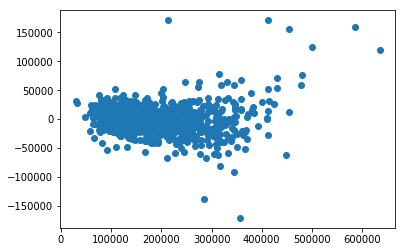

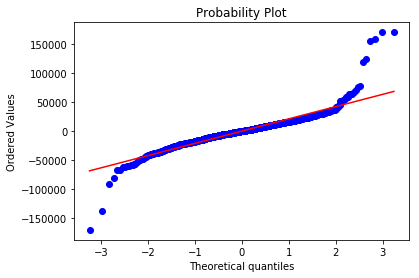

In [217]:
test_predictions = run_model_inputs(train_data, train_id, train_saleprice, test_data, test_id)

In [131]:
# Build a model with all features to simply predict sales price
train_X, validate_X, train_y, validate_y = train_test_split(
    train_data, train_saleprice, test_size=0.2, random_state=43344)

model = sm.OLS(train_y, sm.add_constant(train_X)).fit_regularized(method='elastic_net', alpha=0.5, L1_wt =1)
print('Taking out:', model.params[model.params == 0].shape[0]/model.params.shape[0])
print(model.params[model.params == 0])

Taking out: 0.09836065573770492
Alley_Pave              0.0
Neighborhood_Blueste    0.0
Neighborhood_BrDale     0.0
Condition1_PosN         0.0
Condition1_RRAn         0.0
BldgType_Duplex         0.0
RoofMatl_WdShake        0.0
Exterior1st_AsphShn     0.0
Exterior1st_BrkComm     0.0
Exterior2nd_AsphShn     0.0
Exterior2nd_Brk Cmn     0.0
Exterior2nd_CBlock      0.0
Foundation_Wood         0.0
Functional_Sev          0.0
GarageType_CarPort      0.0
Fence_GdWo              0.0
Fence_MnWw              0.0
MiscFeature_Othr        0.0
dtype: float64


In [132]:
train_data = train_data.drop(columns = ['Alley_Pave', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Condition1_PosN',
                           'Condition1_RRAn', 'BldgType_Duplex', 'RoofMatl_WdShake', 'Exterior1st_AsphShn',
                          'Exterior2nd_Brk Cmn', 'Exterior2nd_CBlock', 'Foundation_Wood', 'Functional_Sev',
                          'GarageType_CarPort', 'Fence_GdWo', 'Fence_MnWw', 'MiscFeature_Othr'])
test_data = test_data.drop(columns = ['Alley_Pave', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Condition1_PosN',
                           'Condition1_RRAn', 'BldgType_Duplex', 'RoofMatl_WdShake', 'Exterior1st_AsphShn',
                          'Exterior2nd_Brk Cmn', 'Exterior2nd_CBlock', 'Foundation_Wood', 'Functional_Sev',
                          'GarageType_CarPort', 'Fence_GdWo', 'Fence_MnWw', 'MiscFeature_Othr'])

print(train_data.shape)
print(test_data.shape)

(1460, 166)
(1459, 166)


R2 is: 0.9189940178222984
Training average percent error is 9.09 %.
Validation average percent error is 11.5 %.
Difference is: 2.42


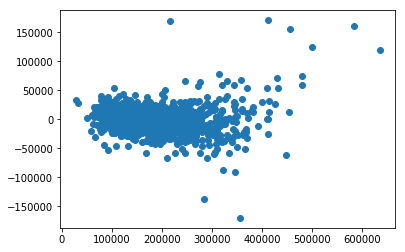

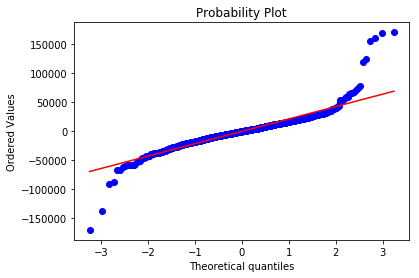

In [133]:
test_predictions = run_model_inputs(train_data, train_id, train_saleprice, test_data, test_id)

#### Model is doing a lot better after taking out terms with params 0 from regulization. Updating the feature_eng_v3 by dropping these columns

#### Applied regulization again and found out the following columns have params of zero (alpha value: 1)
(columns = ['LotShape_Reg', 'HouseStyle_SFoyer', 'Exterior1st_BrkComm',
                                        'Exterior1st_VinylSd', 'Exterior2nd_AsphShn', 'Exterior2nd_CmentBd', 
                                        'Exterior2nd_Wd Shng', 'Heating_Grav', 'PavedDrive_P'])

# LR with feature eng V3

In [176]:
# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')

train_data, train_id = feature_engineering_v3(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v3(test_data)
train_data = train_data[list(test_data.columns)]
print(train_data.shape)
print(test_data.shape)

(1460, 146)
(1459, 146)


#### Dropping the basement int features improves the model so I will add it to feature eng v3

R2 is: 0.9172832650510253
Training average percent error is 9.18 %.
Validation average percent error is 11.22 %.
Difference is: 2.04


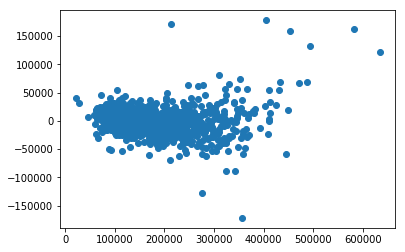

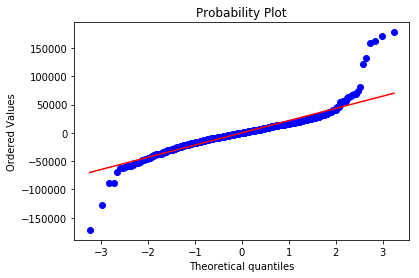

In [138]:
test_predictions = run_model_inputs(train_data, train_id, train_saleprice, test_data, test_id)
# Export submit csv (Score: 0.16778)
# submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
# test_predictions.to_csv(submit_filepath + 'fea_eng_v3.csv', index=False, header=True)

### Applied regulization again and took out the following columns:

columns=['MasVnrAreaBin', '3SsnPorchBin', 'LotShape_IR2', 'Neighborhood_MeadowV', 
                                      'Condition1_PosA', 'Condition1_RRNn']
                                      
columns = ['WoodDeckSFBin', 'LotConfig_FR3', 'Neighborhood_BrkSide',
                                         'Neighborhood_NPkVill', 'Electrical_FuseP', 'PoolQC_Gd']
                                         
columns = ['Exterior2nd_BrkFace', 'Functional_Mod', 'GarageType_Attchd'])

columns = ['HaveBsmt', 'HaveGarage', 'ScreenPorchBin', 'PoolAreaBin', 
                                        'LotShape_IR3', 'Neighborhood_Timber', 'Condition1_Norm', 
                                        'Condition1_RRNe', 'Condition2_PosA', 'Condition2_PosN', 'BldgType_2fmCon', 
                                       'HouseStyle_1.5Unf', 'HouseStyle_2Story', 'Exterior2nd_Stone','Foundation_Slab', 'Heating_Wall'])
                                       
                                       
[v5] columns = ['Have2ndFlr', 'IsRL', 'LandContour_Low', 'LandSlope_Sev', 'BldgType_Twnhs',
                                       'HouseStyle_1Story', 'RoofStyle_Shed', 'Electrical_FuseF'])

[v6] columns = ['ExterCondInt', 'IsNotNormal', 'Exterior1st_CBlock', 'Exterior1st_Stucco',
                                        'HeatingQC_Fa', 'HeatingQC_Po', 'Functional_Typ'])

In [52]:
# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')

train_data, train_id = feature_engineering_v3(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v3(test_data)
train_data = train_data[list(test_data.columns)]
print(train_data.shape)
print(test_data.shape)

(1460, 113)
(1459, 113)


R2 is: 0.9040232309596496
Training average percent error is 9.7 %.
Validation average percent error is 10.94 %.
Difference is: 1.24


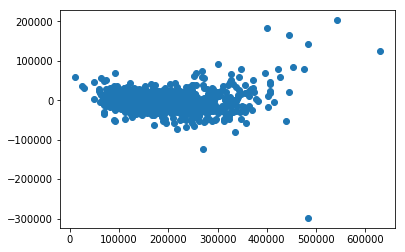

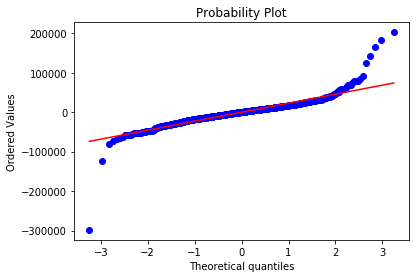

In [53]:
test_predictions = run_model_inputs(train_data, train_id, train_saleprice, test_data, test_id)
# Export submit csv (Score: 0.16656 [v1], 0.16458 [v2], 0.16661 [v3], 0.15725 [v4], 0.15701 [v5], 0.16022 [v6])
# submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
# test_predictions.to_csv(submit_filepath + 'fea_eng_v3_v5.csv', index=False, header=True)

## Taking out SalePrice > 400000 in training data and testing the model

(1460, 81)
(1432, 81)
(1432, 113)
(1459, 113)
R2 is: 0.8781266087803217
Training average percent error is 9.52 %.
Validation average percent error is 9.85 %.
Difference is: 0.32


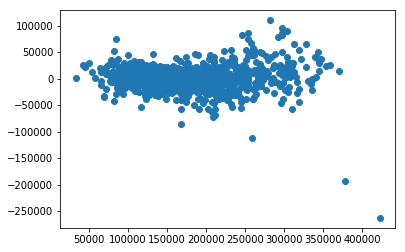

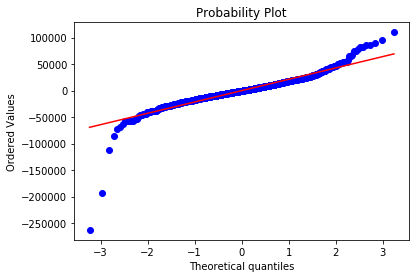

In [60]:
# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')
print(train_data.shape)
train_data = train_data[train_data['SalePrice'] < 400000]
print(train_data.shape)
# print(train_data[train_data['SalePrice'] > 350000])

train_data, train_id = feature_engineering_v3(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v3(test_data)
train_data = train_data[list(test_data.columns)]
print(train_data.shape)
print(test_data.shape)
test_predictions = run_model_inputs(train_data, train_id, train_saleprice, test_data, test_id)
# submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
# test_predictions.to_csv(submit_filepath + 'fea_eng_v3_SP_400000.csv', index=False, header=True)

# Applying PCA to Non-Normalized Data

In [31]:
# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')

train_data, train_id = feature_engineering_v3(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v3(test_data)
train_data = train_data[list(test_data.columns)]
print(train_data.shape)
print(test_data.shape)

(1460, 106)
(1459, 106)


No. of Features: 26
R2 is: 0.8672620381769496
Training average percent error is 11.0 %.
Validation average percent error is 12.23 %.
Difference is: 1.23


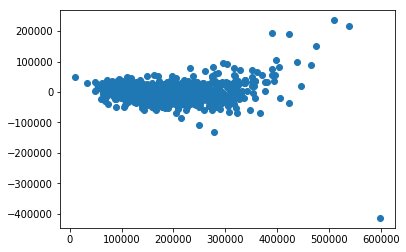

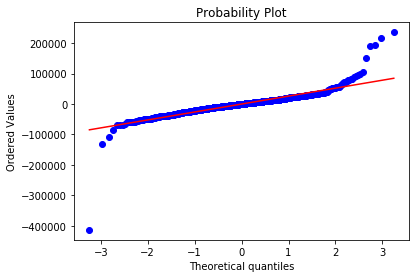

        Id      SalePrice
0     1461  133551.077659
1     1462  324772.638071
2     1463  165233.775029
3     1464  187430.176544
4     1465  204200.811212
5     1466  152021.614366
6     1467  221963.725574
7     1468  160262.601743
8     1469  203310.444507
9     1470  129727.492248
10    1471  242911.808698
11    1472  126747.437862
12    1473  114512.405255
13    1474  163952.071363
14    1475  139058.032769
15    1476  301400.661103
16    1477  236130.916807
17    1478  292949.774819
18    1479  266395.505508
19    1480  454413.813486
20    1481  304659.178270
21    1482  241713.565368
22    1483  164511.906461
23    1484  227391.868079
24    1485  168216.763276
25    1486  195992.088067
26    1487  256245.313369
27    1488  250774.923237
28    1489  195413.468342
29    1490  238606.592500
...    ...            ...
1429  2890  100199.497240
1430  2891  143918.927613
1431  2892   65133.979414
1432  2893   68245.846316
1433  2894   60803.612056
1434  2895  304733.245531
1435  2896  

In [34]:
pca = PCA(n_components=round(train_data.shape[1]/4))
train_components = pca.fit_transform(train_data)
train_pca = pd.DataFrame(data = train_components)
# print(train_pca.head())

test_components = pca.fit_transform(test_data)
test_pca = pd.DataFrame(data = test_components)
# print(test_pca.head())
# print(test_pca.shape)

print('No. of Features:', train_pca.shape[1])

test_predictions = run_model_inputs(train_pca, train_id, train_saleprice, test_pca, test_id)
# print(test_predictions)
# # Export submit csv (Score: 0.63490 [13], 0.50961 [85])
# submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
# test_predictions.to_csv(submit_filepath + 'fea_eng_v3_pca_' + str(train_pca.shape[1]) + '.csv', index=False, header=True)

# Applying PCA to Normalized Data

No. of Features: 15
R2 is: 0.6460756600235967
Training average percent error is 18.37 %.
Validation average percent error is 18.98 %.
Difference is: 0.61


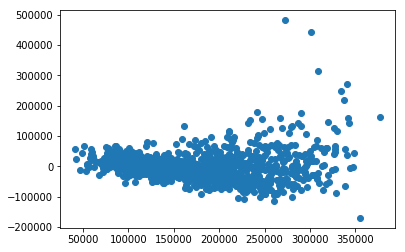

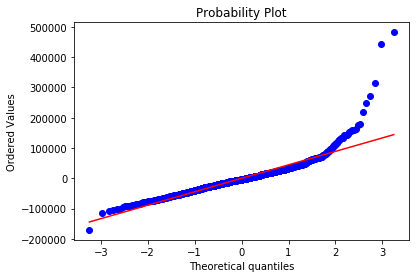

In [25]:
train_data = MinMaxScaler().fit_transform(train_data)
test_data = MinMaxScaler().fit_transform(test_data)

# list_division = [1.25, 1.5, 1.75, 2,4,6,8]
pca = PCA(n_components=round(train_data.shape[1]/7))
train_components = pca.fit_transform(train_data)
train_pca = pd.DataFrame(data = train_components)
# print(train_pca.shape)
# print(train_pca.head())
# print(train_pca.isnull().sum())

test_components = pca.fit_transform(test_data)
test_pca = pd.DataFrame(data = test_components)
# print(test_pca.shape)
# print(test_pca.head())
# print(test_pca.isnull().sum())

print('No. of Features:', train_pca.shape[1])

test_predictions = run_model_inputs(train_pca, train_id, train_saleprice, test_pca, test_id)
# Export submit csv (Score: 0.35035 [26], 1.07551 [85], 0.31719 [13])
# submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
# test_predictions.to_csv(submit_filepath + 'norm_fea_eng_v3_pca_' + str(train_pca.shape[1]) + '.csv', index=False, header=True)

# View Normalized Train PCA plot with 1 component

(1460, 106)
(1459, 106)


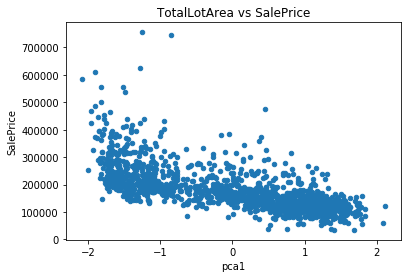

In [41]:
# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')

train_data, train_id = feature_engineering_v3(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v3(test_data)
train_data = train_data[list(test_data.columns)]
print(train_data.shape)
print(test_data.shape)

train_data = MinMaxScaler().fit_transform(train_data)
test_data = MinMaxScaler().fit_transform(test_data)

pca = PCA(n_components=1)
train_components = pca.fit_transform(train_data)
train_pca = pd.DataFrame(data = train_components)

train_pca = pd.concat([train_pca, train_saleprice], axis=1)
train_pca.columns = ['pca1', 'SalePrice']
# print(train_pca)

TotalLotArea_vs_SalePrice = train_pca.plot(
    kind="scatter", x='pca1', y='SalePrice', title = "TotalLotArea vs SalePrice")

# View Un-Normalized Train PCA plot with 1 component

(1460, 106)
(1459, 106)


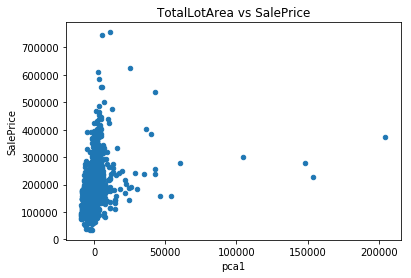

In [42]:
# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')

train_data, train_id = feature_engineering_v3(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v3(test_data)
train_data = train_data[list(test_data.columns)]
print(train_data.shape)
print(test_data.shape)

pca = PCA(n_components=1)
train_components = pca.fit_transform(train_data)
train_pca = pd.DataFrame(data = train_components)

train_pca = pd.concat([train_pca, train_saleprice], axis=1)
train_pca.columns = ['pca1', 'SalePrice']
# print(train_pca)

TotalLotArea_vs_SalePrice = train_pca.plot(
    kind="scatter", x='pca1', y='SalePrice', title = "TotalLotArea vs SalePrice")

### Looks exactly like the TotalLotArea. This is because that field has the highest variance. Thus, it is very important to normalized data for PCA

(1460, 56)
(1459, 56)
R2 is: 0.8846636942495306
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     152.2
Date:                Mon, 13 Aug 2018   Prob (F-statistic):               0.00
Time:                        20:39:11   Log-Likelihood:                -13592.
No. Observations:                1168   AIC:                         2.730e+04
Df Residuals:                    1111   BIC:                         2.759e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

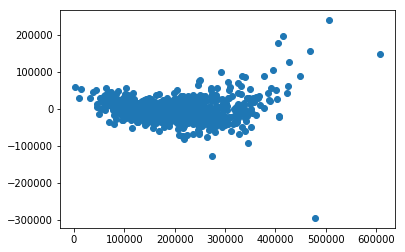

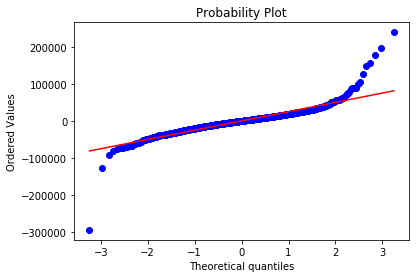

In [92]:
# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')

train_data, train_id = feature_engineering_v3(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v3(test_data)
train_data = train_data[list(test_data.columns)]

train_data = train_data.drop(columns = ['Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 
                                        'Exterior1st_HdBoard', 'Exterior1st_MetalSd', 'Exterior1st_Plywood',
                                       'Exterior1st_Stucco', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 
                                       'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd',
                                       'Exterior2nd_Plywood', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd',
                                       'Exterior2nd_Wd Sdng', 'ExterQualInt', 'ExterCondInt', 'ExterCondQual',
                                       'YearRemodAdd', 'GarageYrBlt', 'GarageCondInt', 'GarageQualInt',
                                       'GarageCondQual', 'MiscFeature_Shed', 'MiscVal', 'KitchenAbvGr', 
                                       'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard'
                                       , 'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageType_Basment', 'GarageType_BuiltIn',
                                       'GarageType_Detchd', 'GarageFinish_RFn', 'GarageFinish_Unf', 'FireplaceQu_TA',
                                       'FireplaceQu_Gd', 'FireplaceQu_Po', 'FireplaceQu_TA', 'FireplaceQu_Fa',
                                       'Heating_GasW', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA',
                                       'Functional_Min2', 'Functional_Maj2', 'Functional_Min1', 'Functional_Typ',
                                       'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Stone',
                                       'LotConfig_Inside', 'LotConfig_FR2', 'LotConfig_CulDSac'])

test_data = test_data.drop(columns = ['Exterior1st_BrkFace', 'Exterior1st_CBlock', 'Exterior1st_CemntBd', 
                                        'Exterior1st_HdBoard', 'Exterior1st_MetalSd', 'Exterior1st_Plywood',
                                       'Exterior1st_Stucco', 'Exterior1st_Wd Sdng', 'Exterior1st_WdShing', 
                                       'Exterior2nd_HdBoard', 'Exterior2nd_ImStucc', 'Exterior2nd_MetalSd',
                                       'Exterior2nd_Plywood', 'Exterior2nd_Stucco', 'Exterior2nd_VinylSd',
                                       'Exterior2nd_Wd Sdng', 'ExterQualInt', 'ExterCondInt', 'ExterCondQual',
                                     'YearRemodAdd', 'GarageYrBlt', 'GarageCondInt', 'GarageQualInt', 
                                     'GarageCondQual', 'MiscFeature_Shed', 'MiscVal', 'KitchenAbvGr', 
                                     'RoofStyle_Gable', 'RoofStyle_Gambrel', 'RoofStyle_Hip', 'RoofStyle_Mansard',
                                     'BedroomAbvGr', 'TotRmsAbvGrd', 'GarageType_Basment', 'GarageType_BuiltIn', 
                                     'GarageType_Detchd', 'GarageFinish_RFn', 'GarageFinish_Unf', 'FireplaceQu_TA',
                                     'FireplaceQu_Gd', 'FireplaceQu_Po', 'FireplaceQu_TA', 'FireplaceQu_Fa', 
                                     'Heating_GasW', 'HeatingQC_Fa', 'HeatingQC_Gd', 'HeatingQC_Po', 'HeatingQC_TA',
                                     'Functional_Min2', 'Functional_Maj2', 'Functional_Min1', 'Functional_Typ',
                                     'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Stone',
                                     'LotConfig_Inside', 'LotConfig_FR2', 'LotConfig_CulDSac'])

print(train_data.shape)
print(test_data.shape)
test_predictions = run_model_inputs(train_data, train_id, train_saleprice, test_data, test_id)
# Export submit csv (Score: 0.25095 [test8])
# submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
# test_predictions.to_csv(submit_filepath + 'fea_eng_v3_test8.csv', index=False, header=True)

(1460, 113)
(1459, 113)
R2 is: 0.9040232309596496
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     90.51
Date:                Tue, 14 Aug 2018   Prob (F-statistic):               0.00
Time:                        22:12:36   Log-Likelihood:                -13485.
No. Observations:                1168   AIC:                         2.719e+04
Df Residuals:                    1057   BIC:                         2.775e+04
Df Model:                         110                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

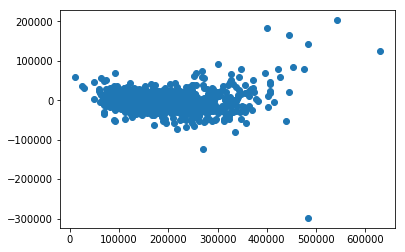

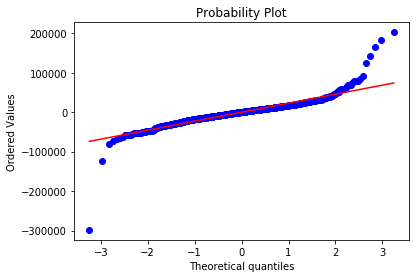

In [47]:
# testing if this is best model
# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')

train_data, train_id = feature_engineering_v3(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v3(test_data)
train_data = train_data[list(test_data.columns)]

print(train_data.shape)
print(test_data.shape)
test_predictions = run_model_inputs(train_data, train_id, train_saleprice, test_data, test_id)
# Export submit csv (Score: 0.15701)
# submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
# test_predictions.to_csv(submit_filepath + 'fea_eng_v3.csv', index=False, header=True)
# test confirmed, that is the best model!

(1460, 113)
(1459, 113)
(45,)
Index(['MSSubClass', 'GrLivArea', 'Fireplaces', 'GarageYrBlt', 'MiscVal',
       'TotalLotArea', 'living_SF', 'TotalSFFeatures',
       'BsmtQualCondExposureType', 'IsNotNormal', 'IsWD', 'SumCondQualFea',
       'LandContour_HLS', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'LandSlope_Mod', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SawyerW',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Veenker',
       'BldgType_TwnhsE', 'HouseStyle_2.5Unf', 'RoofStyle_Gambrel',
       'RoofStyle_Hip', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace',
       'Exterior1st_CemntBd', 'Exterior1st_Stucco', 'Exterior1st_Wd Sdng',
       'Exterior2nd_ImStucc', 'Exterior2nd_Stucco', 'Exterior2nd_Wd Sdng',
       'MasVnrType_Stone', 'Foundation_Stone', 'HeatingQC_Fa',
       'FireplaceQu_Gd', 'GarageType_BuiltIn'

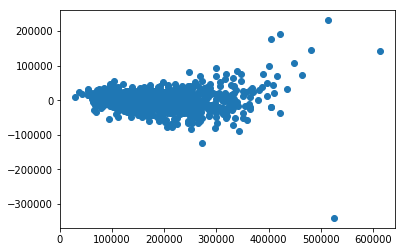

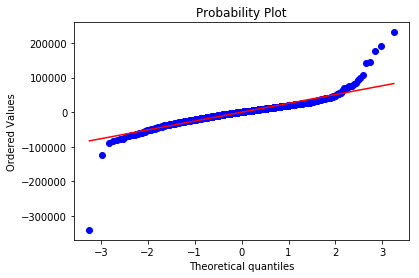

In [54]:
# Take percentile of best model and see what happens
# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')

train_data, train_id = feature_engineering_v3(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v3(test_data)
train_data = train_data[list(test_data.columns)]

print(train_data.shape)
print(test_data.shape)

per = 40
# Use the SelectPercentile function to automatically select a percentile of the dataset
percentile_select = SelectPercentile(score_func=chi2, percentile=per)
percentile_fit = percentile_select.fit(train_data, train_saleprice)
percentile_features_cols = train_data[train_data.columns[percentile_fit.get_support(indices=True)]].columns

train_percentile = train_data[percentile_features_cols]
test_percentile = test_data[percentile_features_cols]
print(percentile_features_cols.shape)
print(percentile_features_cols)

test_predictions = run_model_inputs(train_percentile, train_id, train_saleprice, test_percentile, test_id)
# Export submit csv (Score: 0.15951 [35], 0.15698[45], 0.15913 [50], 0.15488 [40], 0.15842 [30])
# submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
# test_predictions.to_csv(submit_filepath + 'fea_eng_v3_per_' + str(per) +'.csv', index=False, header=True)
# New best model!!

# KNN w 40 Percentile LR

(1460, 113)
(1459, 113)
(45,)
Index(['MSSubClass', 'GrLivArea', 'Fireplaces', 'GarageYrBlt', 'MiscVal',
       'TotalLotArea', 'living_SF', 'TotalSFFeatures',
       'BsmtQualCondExposureType', 'IsNotNormal', 'IsWD', 'SumCondQualFea',
       'LandContour_HLS', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'LandSlope_Mod', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SawyerW',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Veenker',
       'BldgType_TwnhsE', 'HouseStyle_2.5Unf', 'RoofStyle_Gambrel',
       'RoofStyle_Hip', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace',
       'Exterior1st_CemntBd', 'Exterior1st_Stucco', 'Exterior1st_Wd Sdng',
       'Exterior2nd_ImStucc', 'Exterior2nd_Stucco', 'Exterior2nd_Wd Sdng',
       'MasVnrType_Stone', 'Foundation_Stone', 'HeatingQC_Fa',
       'FireplaceQu_Gd', 'GarageType_BuiltIn'

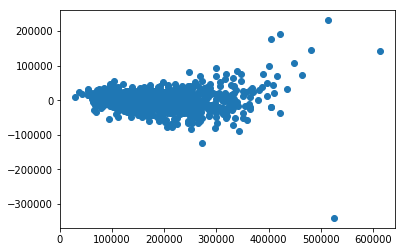

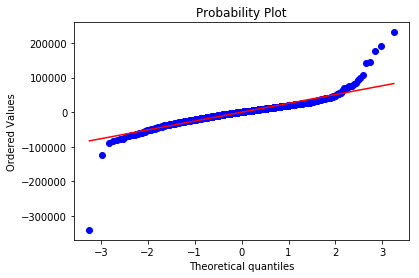

In [66]:
# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')

train_data, train_id = feature_engineering_v3(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v3(test_data)
train_data = train_data[list(test_data.columns)]

print(train_data.shape)
print(test_data.shape)

per = 40
# Use the SelectPercentile function to automatically select a percentile of the dataset
percentile_select = SelectPercentile(score_func=chi2, percentile=per)
percentile_fit = percentile_select.fit(train_data, train_saleprice)
percentile_features_cols = train_data[train_data.columns[percentile_fit.get_support(indices=True)]].columns

train_percentile = train_data[percentile_features_cols]
test_percentile = test_data[percentile_features_cols]
print(percentile_features_cols.shape)
print(percentile_features_cols)

LR_predictions = run_model_inputs(train_percentile, train_id, train_saleprice, test_percentile, test_id)

In [67]:
def k_nearest_neighbors(train_data, train_id, train_saleprice, y, k):
    euc = []
    for i in range(0, np.size(train_data,0), 1):
        euc.append([train_id[i], np.linalg.norm(y-train_data[i]), train_saleprice[i]])
    
    euc_sorted = sorted(euc, key=itemgetter(1))
    
    sum_value = 0
    for i in range(0,k,1):
        sum_value += euc_sorted[i][2]
        
    avg_value = sum_value/k
    return avg_value

In [68]:
# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')

train_data, train_id = feature_engineering_v3(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v3(test_data)
train_data = train_data[list(test_data.columns)]

print(train_data.shape)
print(test_data.shape)

# Normalize the data using MinMaxScaler
train_data = MinMaxScaler().fit_transform(train_data)
test_data = MinMaxScaler().fit_transform(test_data)

knn_predictions = []
k = 5
for i in range(0, np.size(test_data,0), 1):
    knn_predictions.append([test_id[i], k_nearest_neighbors(train_data, train_id, train_saleprice, test_data[i], k)])
    
knn_predictions = pd.DataFrame(knn_predictions, columns=['Id', 'SalePrice'])
print('done!')

(1460, 113)
(1459, 113)
done!


In [69]:
submit_df = LR_predictions
submit_df = submit_df.drop(columns=['SalePrice'])
submit_df['SalePrice'] = 0.85*LR_predictions['SalePrice'] + 0.15*knn_predictions['SalePrice']
# Export submit csv (Score: 0.15923 [50%], 0.14445 [20% knn, 80% lr], 0.14727 [10% knn, 90% lr], 0.14529 [15% knn, 85% lr])
# submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
# submit_df.to_csv(submit_filepath + 'fea_eng_v3_avg_knn_lr_wt85.csv', index=False, header=True)

# Look at Correlation Matrix

### first lets deal with highly correlated features (greater than 70%)

In [275]:
# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')

train_data, train_id = feature_engineering_v3(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v3(test_data)
train_data = train_data[list(test_data.columns)]

print(train_data.shape)
print(test_data.shape)

correlation_mat = train_data.corr()
corr_df = []
for i in range(0, correlation_mat.shape[0], 1):
    for j in range(i+1, correlation_mat.shape[1],1):
        if abs(correlation_mat.iloc[i,j]) >= 0.70:
            corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])

corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
corr_df = corr_df.sort_values(by='correlation', ascending=False)
corr_df

(1460, 113)
(1459, 113)


,col1,col2,correlation
11,GarageQualInt,GarageCondQual,0.986498
10,GarageCondInt,GarageCondQual,0.986168
15,Exterior1st_MetalSd,Exterior2nd_MetalSd,0.973065
4,GarageYrBlt,GarageCondQual,0.947016
9,GarageCondInt,GarageQualInt,0.945707
2,GarageYrBlt,GarageCondInt,0.938987
3,GarageYrBlt,GarageQualInt,0.929219
14,Exterior1st_HdBoard,Exterior2nd_HdBoard,0.883271
8,BsmtQualCondExposureType,SumCondQualFea,0.878922
1,GrLivArea,living_SF,0.874373


#### I cant start by deleted variables I know are correlated and do not need to be in the model

These are the features of the best model so far:

['MSSubClass', 'GrLivArea', 'Fireplaces', 'GarageYrBlt', 'MiscVal',
       'TotalLotArea', 'living_SF', 'TotalSFFeatures',
       'BsmtQualCondExposureType', 'IsNotNormal', 'IsWD', 'SumCondQualFea',
       'LandContour_HLS', 'LotConfig_CulDSac', 'LotConfig_FR2',
       'LandSlope_Mod', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor',
       'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SawyerW',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Veenker',
       'BldgType_TwnhsE', 'HouseStyle_2.5Unf', 'RoofStyle_Gambrel',
       'RoofStyle_Hip', 'RoofMatl_WdShngl', 'Exterior1st_BrkFace',
       'Exterior1st_CemntBd', 'Exterior1st_Stucco', 'Exterior1st_Wd Sdng',
       'Exterior2nd_ImStucc', 'Exterior2nd_Stucco', 'Exterior2nd_Wd Sdng',
       'MasVnrType_Stone', 'Foundation_Stone', 'HeatingQC_Fa',
       'FireplaceQu_Gd', 'GarageType_BuiltIn', 'MiscFeature_Shed']
       
Below, I have deleted features that I know are accounted for in other features. Let's look at the correlation matrix again

In [276]:
train_data = train_data.drop(columns=['GarageQualInt', 'GarageCondInt', 'IsNotTyp', 'BsmtQualCondExposureType',
                                     'Exterior2nd_MetalSd', 'Exterior2nd_HdBoard','Exterior2nd_Wd Sdng',
                                     'Exterior2nd_Plywood', 'Exterior2nd_Stucco', 'ExterQualInt', 'GarageCars',
                                     'ExterCondInt'])

test_data = test_data.drop(columns=['GarageQualInt', 'GarageCondInt', 'IsNotTyp', 'BsmtQualCondExposureType',
                                     'Exterior2nd_MetalSd', 'Exterior2nd_HdBoard','Exterior2nd_Wd Sdng',
                                     'Exterior2nd_Plywood', 'Exterior2nd_Stucco', 'ExterQualInt', 'GarageCars',
                                   'ExterCondInt'])

# deleted BsmtQualCondExposureType because SumCondQualFea should take care of that
# deleted garage_cars because totalsffeatures takes care of it
correlation_mat = train_data.corr()
corr_df = []
for i in range(0, correlation_mat.shape[0], 1):
    for j in range(i+1, correlation_mat.shape[1],1):
        if abs(correlation_mat.iloc[i,j]) >= 0.70:
            corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])

corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
corr_df = corr_df.sort_values(by='correlation', ascending=False)
corr_df

,col1,col2,correlation
2,GarageYrBlt,GarageCondQual,0.947016
1,GrLivArea,living_SF,0.874373
0,GrLivArea,TotRmsAbvGrd,0.825489
5,Foundation_CBlock,Foundation_PConc,-0.781558
4,MasVnrType_BrkFace,MasVnrType_None,-0.797225
3,RoofStyle_Gable,RoofStyle_Hip,-0.933462


#### For the rest of the features, I will apply pca from 2 components to get them down to 1 as I am not sure which feature would be the best to pick in each case

In [277]:
train_data_cols = train_data.columns
train_data = MinMaxScaler().fit_transform(train_data)
train_data = pd.DataFrame(train_data, columns = train_data_cols)

# first lets start with 'GarageYrBlt', 'GarageCondQual'
train_data = apply_pca_on_columns(train_data, ['GarageYrBlt', 'GarageCondQual'], ['GarageYrBlt_GarageCondQual'] , 1)

# next GrLivArea	living_SF
train_data = apply_pca_on_columns(train_data,['GrLivArea', 'living_SF'], ['GrLivArea_living_SF'], 1)

# next RoofStyle_Gable	RoofStyle_Hip
train_data = apply_pca_on_columns(train_data,['RoofStyle_Gable', 'RoofStyle_Hip'], ['RoofStyle_Gable_RoofStyle_Hip'], 1)

# next MasVnrType_BrkFace	MasVnrType_None
train_data = apply_pca_on_columns(train_data,['MasVnrType_BrkFace', 'MasVnrType_None'],['MasVnrType_BrkFace_MasVnrType_None'], 1)

# next Foundation_CBlock	Foundation_PConc
train_data = apply_pca_on_columns(train_data,['Foundation_CBlock', 'Foundation_PConc'],['Foundation_CBlock_Foundation_PConc'], 1)

# next TotRmsAbvGrd	GrLivArea_living_SF
train_data = apply_pca_on_columns(train_data,['TotRmsAbvGrd', 'GrLivArea_living_SF'],['TotRmsAbvGrd_GrLivArea_living_SF'], 1)

print(train_data.shape)
train_data.head()

(1460, 95)


,MSSubClass,YearBuilt,YearRemodAdd,BedroomAbvGr,KitchenAbvGr,Fireplaces,MiscVal,TotalLotArea,OpenPorchSFBin,EnclosedPorchBin,...,GarageFinish_Unf,PavedDrive_Y,Fence_MnPrv,MiscFeature_Shed,num_bathroom,GarageYrBlt_GarageCondQual,RoofStyle_Gable_RoofStyle_Hip,MasVnrType_BrkFace_MasVnrType_None,Foundation_CBlock_Foundation_PConc,TotRmsAbvGrd_GrLivArea_living_SF
0,0.235294,0.949275,0.883333,0.375,0.333333,0.000000,0.0,0.033592,1.0,0.0,...,0.0,1.0,0.0,0.0,0.5,-0.075733,-0.29329,0.906269,-0.700933,0.113588
1,0.000000,0.753623,0.433333,0.375,0.333333,0.333333,0.0,0.039034,0.0,0.0,...,0.0,1.0,0.0,0.0,0.3,-0.064096,-0.29329,-0.506753,0.713279,-0.059658
2,0.235294,0.934783,0.866667,0.375,0.333333,0.333333,0.0,0.046685,1.0,0.0,...,0.0,1.0,0.0,0.0,0.5,-0.074871,-0.29329,0.906269,-0.700933,-0.001309
3,0.294118,0.311594,0.333333,0.375,0.333333,0.333333,0.0,0.038707,1.0,1.0,...,1.0,1.0,0.0,0.0,0.2,-0.073578,-0.29329,-0.506753,0.007176,0.047759
4,0.235294,0.927536,0.833333,0.500,0.333333,0.333333,0.0,0.060821,1.0,0.0,...,0.0,1.0,0.0,0.0,0.5,-0.074440,-0.29329,0.906269,-0.700933,0.251116


In [278]:
test_data_cols = test_data.columns
test_data = MinMaxScaler().fit_transform(test_data)
test_data = pd.DataFrame(test_data, columns = test_data_cols)

# first lets start with 'GarageYrBlt', 'GarageCondQual'
test_data = apply_pca_on_columns(test_data, ['GarageYrBlt', 'GarageCondQual'], ['GarageYrBlt_GarageCondQual'] , 1)

# next GrLivArea	living_SF
test_data = apply_pca_on_columns(test_data,['GrLivArea', 'living_SF'], ['GrLivArea_living_SF'], 1)

# next RoofStyle_Gable	RoofStyle_Hip
test_data = apply_pca_on_columns(test_data,['RoofStyle_Gable', 'RoofStyle_Hip'], ['RoofStyle_Gable_RoofStyle_Hip'], 1)

# next MasVnrType_BrkFace	MasVnrType_None
test_data = apply_pca_on_columns(test_data,['MasVnrType_BrkFace', 'MasVnrType_None'],['MasVnrType_BrkFace_MasVnrType_None'], 1)

# next Foundation_CBlock	Foundation_PConc
test_data = apply_pca_on_columns(test_data,['Foundation_CBlock', 'Foundation_PConc'],['Foundation_CBlock_Foundation_PConc'], 1)

# next TotRmsAbvGrd	GrLivArea_living_SF
test_data = apply_pca_on_columns(test_data,['TotRmsAbvGrd', 'GrLivArea_living_SF'],['TotRmsAbvGrd_GrLivArea_living_SF'], 1)

print(test_data.shape)
test_data.head()

(1459, 95)


,MSSubClass,YearBuilt,YearRemodAdd,BedroomAbvGr,KitchenAbvGr,Fireplaces,MiscVal,TotalLotArea,OpenPorchSFBin,EnclosedPorchBin,...,GarageFinish_Unf,PavedDrive_Y,Fence_MnPrv,MiscFeature_Shed,num_bathroom,GarageYrBlt_GarageCondQual,RoofStyle_Gable_RoofStyle_Hip,MasVnrType_BrkFace_MasVnrType_None,Foundation_CBlock_Foundation_PConc,TotRmsAbvGrd_GrLivArea_living_SF
0,0.000000,0.625954,0.183333,0.333333,0.5,0.00,0.000000,0.185287,0.0,0.0,...,1.0,1.0,1.0,0.0,0.000000,-0.057734,-0.269158,-0.494515,0.735455,-0.186177
1,0.000000,0.603053,0.133333,0.500000,0.5,0.00,0.735294,0.233301,1.0,0.0,...,1.0,1.0,0.0,0.0,0.083333,-0.056627,1.144821,0.918408,0.735455,-0.035564
2,0.235294,0.900763,0.800000,0.500000,0.5,0.25,0.000000,0.225245,1.0,0.0,...,0.0,1.0,1.0,0.0,0.250000,-0.071014,-0.269158,-0.494515,-0.678719,-0.003830
3,0.235294,0.908397,0.800000,0.500000,0.5,0.25,0.000000,0.155419,1.0,0.0,...,0.0,1.0,0.0,0.0,0.250000,-0.071383,-0.269158,0.918408,-0.678719,0.050211
4,0.588235,0.862595,0.700000,0.333333,0.5,0.00,0.000000,0.064545,1.0,0.0,...,0.0,1.0,0.0,0.0,0.166667,-0.069170,-0.269158,-0.494515,-0.678719,-0.104231


In [279]:
# test if there are any correlations left
correlation_mat = train_data.corr()
corr_df = []
for i in range(0, correlation_mat.shape[0], 1):
    for j in range(i+1, correlation_mat.shape[1],1):
        if abs(correlation_mat.iloc[i,j]) >= 0.70:
            corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])

corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
corr_df = corr_df.sort_values(by='correlation', ascending=False)
corr_df

print(train_data.shape)
print(test_data.shape)

(1460, 95)
(1459, 95)


R2 is: 0.889148632276042
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.889
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     90.51
Date:                Fri, 17 Aug 2018   Prob (F-statistic):               0.00
Time:                        07:41:29   Log-Likelihood:                -13569.
No. Observations:                1168   AIC:                         2.733e+04
Df Residuals:                    1072   BIC:                         2.782e+04
Df Model:                          95                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------

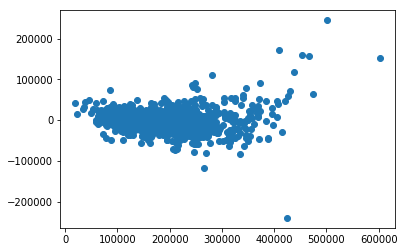

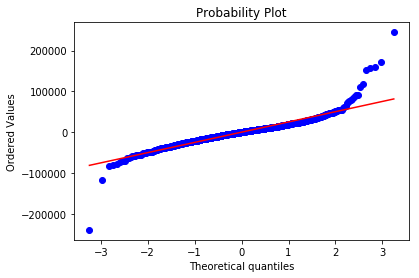

     Id      SalePrice
0  1461  126639.548528
1  1462  156941.371652
2  1463  172086.659412
3  1464  187714.687373
4  1465  210976.010628


In [280]:
test_predictions = run_model_inputs(train_data, train_id, train_saleprice, test_data, test_id)
print(test_predictions.head())
# Export submit csv (Score: 0.14529)
# submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
# submit_df.to_csv(submit_filepath + 'fea_eng_v3_corrpca_07.csv', index=False, header=True)

#### From viewing the coefficients of the model above, they make a lot more sense than before. For example, the higher the kitchencondqual the higher the value of the house.

# Get percentile model after taking out correlation greater than 0.7

(19,)
Index(['YearBuilt', 'MiscVal', 'TotalLotArea', 'TotalSFFeatures',
       'OverallCondQual', 'ExterCondQual', 'KitchenQualInt', 'IsWD',
       'SumCondQualFea', 'Street_Pave', 'Neighborhood_NoRidge',
       'Neighborhood_NridgHt', 'Neighborhood_Somerst', 'Neighborhood_Veenker',
       'Exterior1st_CemntBd', 'MasVnrType_Stone', 'Foundation_Stone',
       'num_bathroom', 'TotRmsAbvGrd_GrLivArea_living_SF'],
      dtype='object')
R2 is: 0.8294321402933824
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.829
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     293.8
Date:                Fri, 17 Aug 2018   Prob (F-statistic):               0.00
Time:                        07:41:59   Log-Likelihood:                -13821.
No. Observations:                1168   AIC:                    

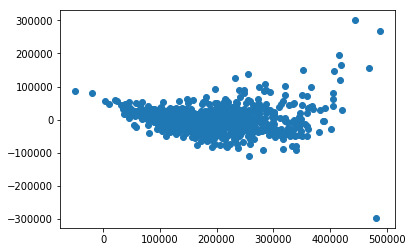

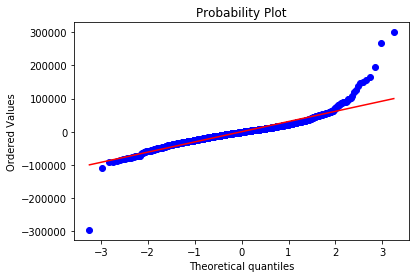

     Id      SalePrice
0  1461  156740.991626
1  1462  193370.714592
2  1463  201582.710619
3  1464  226567.752636
4  1465  191078.316867


In [281]:
per = 20
# Use the SelectPercentile function to automatically select a percentile of the dataset
percentile_select = SelectPercentile(score_func=f_classif, percentile=per)
percentile_fit = percentile_select.fit(train_data, train_saleprice)
percentile_features_cols = train_data[train_data.columns[percentile_fit.get_support(indices=True)]].columns

train_percentile = train_data[percentile_features_cols]
test_percentile = test_data[percentile_features_cols]
print(percentile_features_cols.shape)
print(percentile_features_cols)

test_predictions = run_model_inputs(train_percentile, train_id, train_saleprice, test_percentile, test_id)
print(test_predictions.head())
# Export submit csv (Score: 0.23068 [20], 0.17124 [50], 0.18560 [40])
# submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
# test_predictions.to_csv(submit_filepath + 'fea_eng_v3_corr_07_per_' + str(per) +'.csv', index=False, header=True)

# Let's see if there are other features that are slighly correlated and affecting the model

In [282]:
correlation_mat = train_percentile.corr()
corr_df = []
for i in range(0, correlation_mat.shape[0], 1):
    for j in range(i+1, correlation_mat.shape[1],1):
        if abs(correlation_mat.iloc[i,j]) >= 0.6:
            corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])

corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
corr_df = corr_df.sort_values(by='correlation', ascending=False)
corr_df

,col1,col2,correlation
3,KitchenQualInt,SumCondQualFea,0.676661
2,ExterCondQual,SumCondQualFea,0.656957
1,ExterCondQual,KitchenQualInt,0.638352
0,OverallCondQual,SumCondQualFea,0.613299


In [283]:
train_data = train_data.drop(columns=['KitchenQualInt', 'ExterCondQual', 'OverallCondQual'])
# deleted because all three features are taken into account in sumcondqualfea
## Apply for test data
test_data = test_data.drop(columns=['KitchenQualInt', 'ExterCondQual', 'OverallCondQual'])

correlation_mat = train_data.corr()
corr_df = []
for i in range(0, correlation_mat.shape[0], 1):
    for j in range(i+1, correlation_mat.shape[1],1):
        if abs(correlation_mat.iloc[i,j]) >= 0.6:
            corr_df.append([correlation_mat.columns[i], correlation_mat.columns[j], correlation_mat.iloc[i,j]])

corr_df = pd.DataFrame(corr_df, columns=['col1', 'col2', 'correlation'])
corr_df = corr_df.sort_values(by='correlation', ascending=False)
corr_df

,col1,col2,correlation
1,IsNotNormal,IsWD,0.634322
0,BedroomAbvGr,TotRmsAbvGrd_GrLivArea_living_SF,0.623935
3,GarageType_Detchd,GarageFinish_Unf,0.609983
2,Condition2_Feedr,Condition2_Norm,-0.630495


In [284]:
# for IsNotNormal	IsWD
train_data = apply_pca_on_columns(train_data,['IsNotNormal', 'IsWD'],['IsNotNormal_IsWD'], 1)

# # For GarageType_Detchd	GarageFinish_Unf
train_data = apply_pca_on_columns(train_data,['GarageType_Detchd', 'GarageFinish_Unf'],['GarageType_Detchd_GarageFinish_Unf'], 1)

# # For Condition2_Feedr	Condition2_Norm
train_data = apply_pca_on_columns(train_data,['Condition2_Feedr', 'Condition2_Norm'],['Condition2_Feedr_Condition2_Norm'], 1)

# # FOR BedroomAbvGr	TotRmsAbvGrd_GrLivArea_living_SF
train_data = apply_pca_on_columns(train_data,['BedroomAbvGr', 'TotRmsAbvGrd_GrLivArea_living_SF'],['BedroomAbvGr_TotRmsAbvGrd_GrLivArea_living_SF'], 1)


## Apply for test data
# for IsNotNormal	IsWD
test_data = apply_pca_on_columns(test_data,['IsNotNormal', 'IsWD'],['IsNotNormal_IsWD'], 1)

# # For GarageType_Detchd	GarageFinish_Unf
test_data = apply_pca_on_columns(test_data,['GarageType_Detchd', 'GarageFinish_Unf'],['GarageType_Detchd_GarageFinish_Unf'], 1)

# # For Condition2_Feedr	Condition2_Norm
test_data = apply_pca_on_columns(test_data,['Condition2_Feedr', 'Condition2_Norm'],['Condition2_Feedr_Condition2_Norm'], 1)

# # FOR BedroomAbvGr	TotRmsAbvGrd_GrLivArea_living_SF
test_data = apply_pca_on_columns(test_data,['BedroomAbvGr', 'TotRmsAbvGrd_GrLivArea_living_SF'],['BedroomAbvGr_TotRmsAbvGrd_GrLivArea_living_SF'], 1)



R2 is: 0.8746507988770202
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.864
Method:                 Least Squares   F-statistic:                     85.56
Date:                Fri, 17 Aug 2018   Prob (F-statistic):               0.00
Time:                        07:42:52   Log-Likelihood:                -13641.
No. Observations:                1168   AIC:                         2.746e+04
Df Residuals:                    1079   BIC:                         2.791e+04
Df Model:                          88                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------

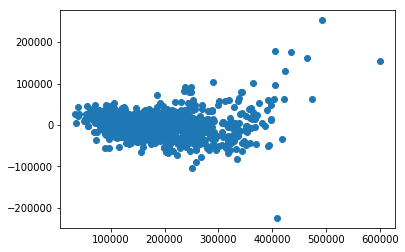

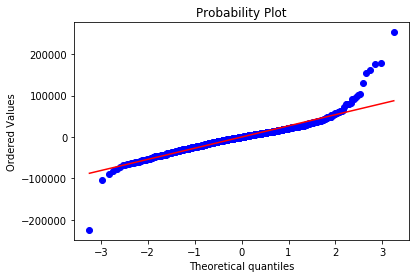

     Id      SalePrice
0  1461  107431.816521
1  1462  151921.964693
2  1463  183341.740721
3  1464  184457.959646
4  1465  199216.615427


In [285]:
test_predictions = run_model_inputs(train_data, train_id, train_saleprice, test_data, test_id)
print(test_predictions.head())
# Export submit csv (Score: 0.14529)
# submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
# submit_df.to_csv(submit_filepath + 'fea_eng_v3_corrpca_06.csv', index=False, header=True)

(44,)
Index(['YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MiscVal', 'TotalLotArea',
       'OpenPorchSFBin', 'TotalSFFeatures', 'SumCondQualFea', 'Street_Pave',
       'LandContour_HLS', 'LotConfig_CulDSac', 'LandSlope_Mod',
       'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Gilbert',
       'Neighborhood_IDOTRR', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Veenker',
       'BldgType_TwnhsE', 'RoofStyle_Gambrel', 'RoofMatl_WdShngl',
       'Exterior1st_CemntBd', 'Exterior1st_Stucco', 'Exterior2nd_VinylSd',
       'MasVnrType_Stone', 'Foundation_Stone', 'HeatingQC_TA', 'CentralAir_Y',
       'Electrical_SBrkr', 'FireplaceQu_Gd', 'FireplaceQu_TA',
       'GarageType_BuiltIn', 'GarageFinish_RFn', 'num_bathroom',
       'GarageYrBlt_GarageCondQual', 'RoofStyle_Gable_RoofStyle_Hip',
       'MasVnrType_BrkFace_MasVnrType_None',
       'Foundation_CBlock_Foundation_PConc', 'IsNotNormal_IsWD',
       'Gar

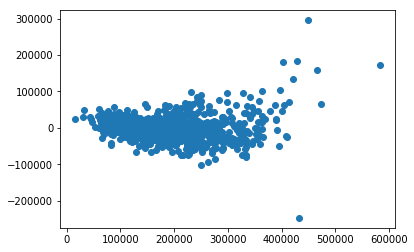

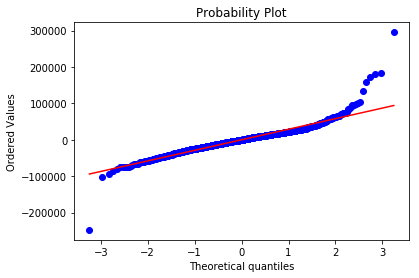

In [252]:
per = 50
# Use the SelectPercentile function to automatically select a percentile of the dataset
percentile_select = SelectPercentile(score_func=f_classif, percentile=per)
percentile_fit = percentile_select.fit(train_data, train_saleprice)
percentile_features_cols = train_data[train_data.columns[percentile_fit.get_support(indices=True)]].columns

train_percentile = train_data[percentile_features_cols]
test_percentile = test_data[percentile_features_cols]
print(percentile_features_cols.shape)
print(percentile_features_cols)

test_predictions = run_model_inputs(train_percentile, train_id, train_saleprice, test_percentile, test_id)
# Export submit csv (Score: )
# submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
# test_predictions.to_csv(submit_filepath + 'fea_eng_v3_corr_06_per_' + str(per) +'.csv', index=False, header=True)

R2 is: 0.8936095860831467
                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.884
Method:                 Least Squares   F-statistic:                     92.65
Date:                Tue, 14 Aug 2018   Prob (F-statistic):               0.00
Time:                        22:06:00   Log-Likelihood:                -13545.
No. Observations:                1168   AIC:                         2.729e+04
Df Residuals:                    1070   BIC:                         2.778e+04
Df Model:                          97                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const 

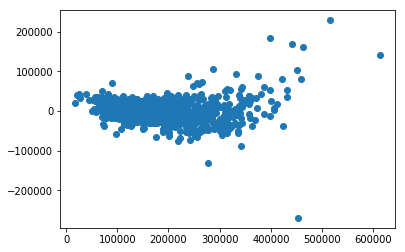

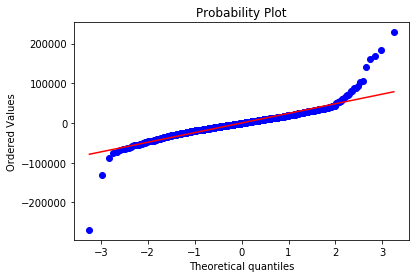

In [39]:
train_data = train_data.drop(columns = ['GrLivArea', 'GarageCondInt', 'GarageQualInt', 'GarageYrBlt', 
                                        'ExterQualInt', 'ExterCondQual', 'BsmtQualCondExposureType', 'IsNotTyp',
                                       'RoofStyle_Gable', 'RoofStyle_Hip', 'Exterior1st_HdBoard', 
                                        'Exterior2nd_HdBoard', 'Exterior1st_MetalSd', 'Exterior2nd_MetalSd',
                                       'Exterior1st_Wd Sdng', 'Exterior2nd_Wd Sdng'])
test_data = test_data.drop(columns = ['GrLivArea', 'GarageCondInt', 'GarageQualInt', 'GarageYrBlt', 
                                        'ExterQualInt', 'ExterCondQual', 'BsmtQualCondExposureType', 'IsNotTyp',
                                       'RoofStyle_Gable', 'RoofStyle_Hip', 'Exterior1st_HdBoard', 
                                        'Exterior2nd_HdBoard', 'Exterior1st_MetalSd', 'Exterior2nd_MetalSd',
                                       'Exterior1st_Wd Sdng', 'Exterior2nd_Wd Sdng'])
test_predictions = run_model_inputs(train_data, train_id, train_saleprice, test_data, test_id)
# Export submit csv (Score: 0.25095 [test8])
# submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
# test_predictions.to_csv(submit_filepath + 'fea_eng_v3_test9.csv', index=False, header=True)

# Random Forrest

In [327]:
from sklearn.ensemble import RandomForestClassifier

# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')

train_data, train_id = feature_engineering_v3(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v3(test_data)
train_data = train_data[list(test_data.columns)]

print(train_data.shape)
print(test_data.shape)

train_X, validate_X, train_y, validate_y = train_test_split(
        train_data, train_saleprice, test_size=0.2, random_state=344)

(1460, 113)
(1459, 113)


In [328]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(train_X, train_y)
train_predictions = model.predict(validate_X)
test_predictions = model.predict(test_data)
test_predictions = pd.DataFrame(test_predictions)
test_predictions.columns = ['SalePrice']
test_predictions = pd.concat([test_id, test_predictions], axis=1)
# # Export submit csv (Score: 0.18743)
# submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
# test_predictions.to_csv(submit_filepath + 'fea_eng_v3_RF.csv', index=False, header=True)

In [326]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

print('MAE:', mean_absolute_error(validate_y, train_predictions))
print('MSLE:', mean_squared_log_error(validate_y, train_predictions))

MAE: 25779.222602739726
MSLE: 0.04703715257071726


In [323]:
# Read in the test data and perform the same feature engineering as done with the train data
# read in the data
filepath = '//Users//josephcolaco//predicting_house_prices//data//'
train_data = pd.read_csv(filepath + 'train.csv')
test_data = pd.read_csv(filepath + 'test.csv')

train_data, train_id = feature_engineering_v3(train_data)
train_saleprice = train_data['SalePrice']
test_data, test_id = feature_engineering_v3(test_data)
train_data = train_data[list(test_data.columns)]

print(train_data.shape)
print(test_data.shape)

per = 40
# Use the SelectPercentile function to automatically select a percentile of the dataset
percentile_select = SelectPercentile(score_func=f_classif, percentile=per)
percentile_fit = percentile_select.fit(train_data, train_saleprice)
percentile_features_cols = train_data[train_data.columns[percentile_fit.get_support(indices=True)]].columns

train_percentile = train_data[percentile_features_cols]
test_percentile = test_data[percentile_features_cols]
print(percentile_features_cols.shape)
print(percentile_features_cols)

train_X, validate_X, train_y, validate_y = train_test_split(
        train_percentile, train_saleprice, test_size=0.2, random_state=344)

model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(train_X, train_y)
train_predictions = model.predict(validate_X)
test_predictions = model.predict(test_percentile)
test_predictions = pd.DataFrame(test_predictions)
test_predictions.columns = ['SalePrice']
test_predictions = pd.concat([test_id, test_predictions], axis=1)

print('MAE:', mean_absolute_error(validate_y, train_predictions))
print('MSLE:', mean_squared_log_error(validate_y, train_predictions))

# Export submit csv (Score: 0.19731 [40])
# submit_filepath = '//Users//josephcolaco//predicting_house_prices//'
# test_predictions.to_csv(submit_filepath + 'fea_eng_v3_RF_per_' + str(per) +'.csv', index=False, header=True)

(1460, 113)
(1459, 113)
(45,)
Index(['YearBuilt', 'YearRemodAdd', 'GrLivArea', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageCars', 'MiscVal', 'TotalLotArea', 'living_SF', 'OpenPorchSFBin',
       'TotalSFFeatures', 'OverallCondQual', 'ExterQualInt', 'ExterCondQual',
       'BsmtQualCondExposureType', 'GarageQualInt', 'GarageCondQual',
       'KitchenQualInt', 'IsNotNormal', 'IsWD', 'SumCondQualFea',
       'Street_Pave', 'LandContour_HLS', 'Neighborhood_CollgCr',
       'Neighborhood_Crawfor', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt',
       'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Veenker',
       'RoofStyle_Gambrel', 'RoofMatl_WdShngl', 'Exterior1st_CemntBd',
       'Exterior1st_Stucco', 'Exterior2nd_VinylSd', 'MasVnrType_Stone',
       'Foundation_CBlock', 'Foundation_PConc', 'Foundation_Stone',
       'CentralAir_Y', 'FireplaceQu_Gd', 'GarageType_BuiltIn',
       'GarageFinish_RFn', 'GarageFinish_Unf', 'num_bathroom'],
      dtype='object')
MAE: 22795.6061